In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time

from collections import OrderedDict
import torch
from torchvision import transforms, models
import dataset_interfaces
import training_helper

## Defining Interface to Load Dataset

### Define Transformations to Apply to Images to Load

The densenet pretrained model for this experiment requires the input to be 224x224 images. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [2]:
# For training, we apply special transformations like random rotation and horizontal flip to to data augmentation
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((240, 240)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

### Defining Interface and Data Loaders
We have created a helper module called *'dataset_interfaces.py'* to aid with the interfacing to the dataset. We are relying in Google Collab to accelerate the training process. If this is not being used, change the flag below to False.

In [3]:
# Set this flag to indicate if we are using Google Collab for the training process
using_collab = True

In [4]:
# Defining general parameters for the data loading
batch_size = 64
# 20% of the training data will be used to validate the model as it trains
# This helps visualizing if it is overfitting and to save the model with the lowest loss for validation
validation_size=0.2
# Name of the classes to load
classes_names = ['BOTTLE_OPENER', 'DINNER_FORK', 'DINNER_KNIFE', 'FISH_SLICE', 'KITCHEN_KNIFE', 'LADLE', 
                 'POTATO_PEELER', 'SPATULA', 'SPOON', 'TONGS', 'WHISK']
num_classes = len(classes_names)

In [5]:
if using_collab:
    # We are going to mount google drive to interface with the dataset
    from google.colab import drive
    drive.mount('/content/drive')
    # Ensure the dataset is uploaded to the next location in your google drive account
    dataset_dir = '/content/drive/My Drive/Colab Notebooks/dataset'
    
    # Since loading images from drive every time is very slow, we load the images into a memory-mapped H5 file
    # The created interface is used for this purpose
    dataset_int = dataset_interfaces.H5FileDatasetInterface(dataset_dir, 
                                                            classes_names=classes_names,
                                                            batch_size=batch_size, 
                                                            validation_size=validation_size,
                                                            train_transform=train_transforms,
                                                            test_transform=test_transforms,
                                                            images_size=256)
else:
    # We are not using collab. Running in the local computer instead
    # Just give relative path to dataset directory
    dataset_dir = '../dataset'
    
    # We will use an interface that can interact with the images in the folder
    dataset_int = dataset_interfaces.ImgFolderDatasetInterface(dataset_dir, 
                                                               classes_names=classes_names,
                                                               batch_size=batch_size, 
                                                               validation_size=validation_size,
                                                               train_transform=train_transforms,
                                                               test_transform=test_transforms)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating h5 file 'data_training.h5' with 440 samples from path '/content/drive/My Drive/Colab Notebooks/dataset/train'
New class idx 0 for class_name BOTTLE_OPENER
New class idx 1 for class_name DINNER_FORK
New class idx 2 for class_name DINNER_KNIFE
New class idx 3 for class_name FISH_SLICE
New class idx 4 for class_name KITCHEN_KNIFE
New class idx 5 for class_name LADLE
New class idx 6 for class_name POTATO_PEELER
New class idx 7 for class_name SPATULA
New class idx 8 for class_name SPOON
New class idx 9 for class_name TONGS
New class idx 10 for class_name WHISK
Creating h5 file 'data_test.h5' with 104 samples from path '/content/drive/My Drive/Colab Notebooks/dataset/test'
New class idx 0 for class_name BOTTLE_OPENER
New class idx 1 for class_name DINNER_FORK
New class idx 2 for class_name DINNER_KNIFE
New class idx 3 for class_name FISH_SLICE
New class id

In [6]:
# Now retrieve the data-loaders from the created interface
train_loader = dataset_int.get_training_loader()
valid_loader = dataset_int.get_validation_loader()
test_loader = dataset_int.get_testing_loader()

### Display Training Images
Below we display some of the training images to confirm they were loaded as expected.

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

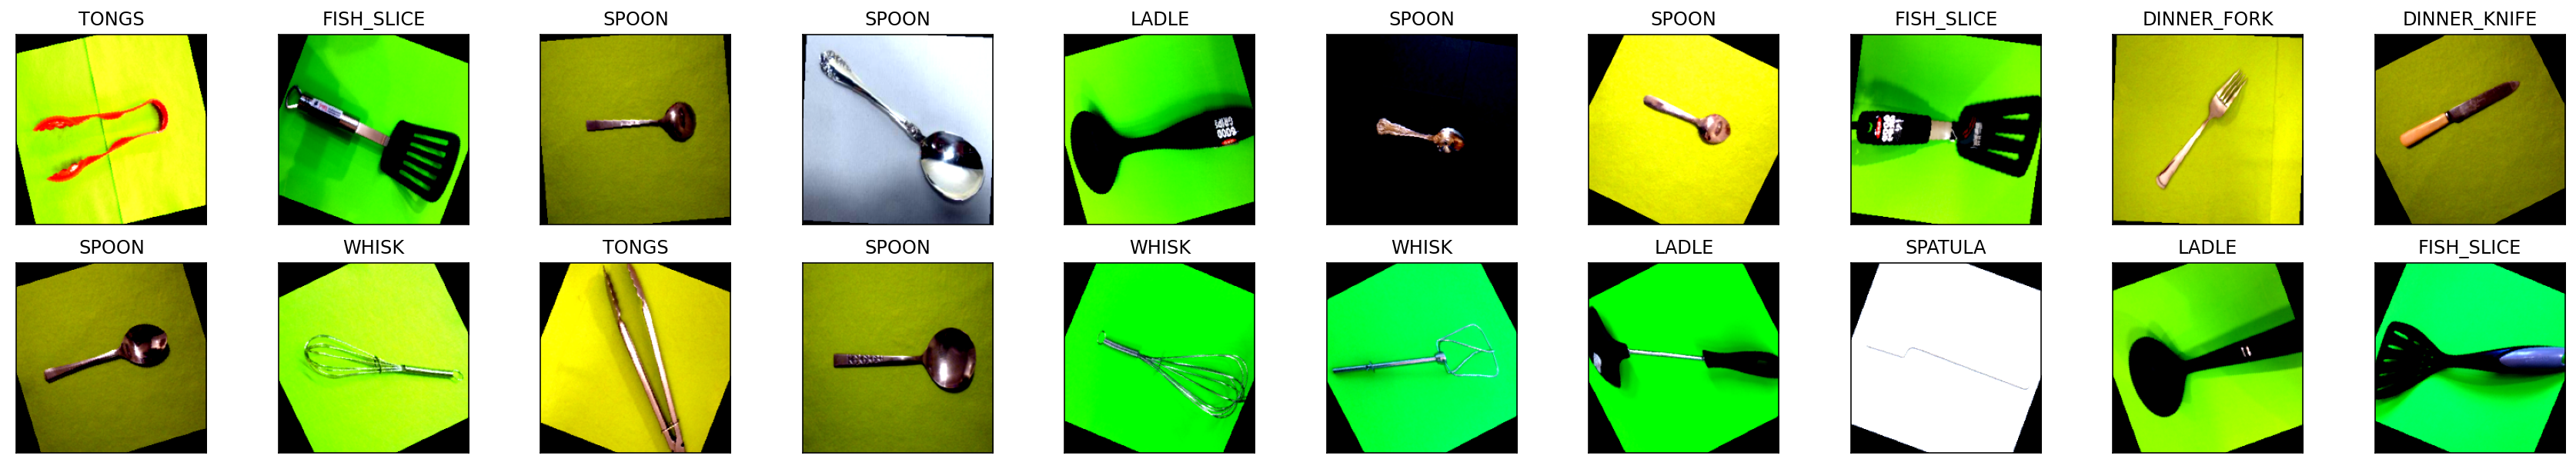

In [7]:
dataset_int.plot_training_images(num_images=20)

## Defining the Model
### Pre-Trained Feature Extractor
For this experiment, we will rely on a pre-trained Densenet model with 121 layers for the features extraction.

In [8]:
# Define already trained Densetnet model
model = models.densenet121(pretrained=True)
# Disable gradient in the parameters of the model, since we don't want to train it again
for param in model.parameters():
    param.requires_grad = False

### Fully-Connected Layer for Classification
The last portion of the model is a fully-connected layer (FCL). We do customize this portion for our specific task. The number of outputs in the final layer is determined by the number of classes (num_classes) variable defined above.

In [9]:
# Define custom classifier as FCL
classifier = torch.nn.Sequential(OrderedDict([('fc1', torch.nn.Linear(1024, 512)),
                                              ('relu', torch.nn.ReLU()),
                                              ('fc2', torch.nn.Linear(512, num_classes)),
                                              ('output', torch.nn.LogSoftmax(dim=1))
                                             ]))
    
# Override classifier in model with our custom FCL
model.classifier = classifier

## Performing Training

In [10]:
# General Parameters for the training
n_epochs = 10
learning_rate=0.003

In [11]:
# Define criterion function for loss
criterion = torch.nn.NLLLoss()
# Use an Adam classifier to train parameters in classifier portion of the model (FCL)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Determine device to use for training (to use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device {}".format(device))

Using device cuda


In [12]:
# Init variables
start_time = time.time()
valid_loss_min = 1e9
# Iterate for each of the epochs
for epoch in range(1, n_epochs+1):
    print("DEBUG: Starting epoch {}".format(epoch))
    # Perform training for this epoch and obtain its average loss
    train_loss = training_helper.train_epoch(optimizer, model, criterion, train_loader, device)
    
    # Perform validation for this epoch and obtain its average loss
    valid_loss = training_helper.validate_epoch(model, criterion, valid_loader, device)
    
    # Print loss for training and validation
    print('>> Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(epoch, train_loss, valid_loss))
    
    # # Save model to disk only if validation loss hass decreased
    if valid_loss <= valid_loss_min:
        print('>>>>>>>> Validation loss decreased. Saving model!')
        torch.save(model.state_dict(), 'densenet_exp_model.pt')
        valid_loss_min = valid_loss

# Finished training. Print elapsed time
end_time = time.time()
print(" =============== Finished Training, elapsed time: {} seconds ============== ".format(end_time-start_time))

DEBUG: Starting epoch 1
>> Epoch: 1 	Training Loss: 2.68571 	Validation Loss: 2.22151
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 2
>> Epoch: 2 	Training Loss: 1.92974 	Validation Loss: 1.77721
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 3
>> Epoch: 3 	Training Loss: 1.40605 	Validation Loss: 1.38935
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 4
>> Epoch: 4 	Training Loss: 1.03337 	Validation Loss: 1.13117
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 5
>> Epoch: 5 	Training Loss: 0.76389 	Validation Loss: 1.06120
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 6
>> Epoch: 6 	Training Loss: 0.60581 	Validation Loss: 0.86462
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 7
>> Epoch: 7 	Training Loss: 0.46783 	Validation Loss: 0.85018
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 8
>> Epoch: 8 	Training Lo

## Testing Model
Now we will use the saved model with the lowest validation loss to evaluate its predictions on the testing portion of the dataset.

In [13]:
# Load best model
model.load_state_dict(torch.load('densenet_exp_model.pt'))

<All keys matched successfully>

In [14]:
# Run test evaluation and collect results dictionary
results = training_helper.test_eval(num_classes, model, criterion, test_loader, device)

# Print results
print('Test Loss: {:.5f}\n'.format(results['test_loss_avg']))
classes_results = results['classes_results']
for idx in range(num_classes):
    class_results = classes_results[idx]
    class_name = classes_names[idx]
    print("Class '{}'. Accuracy: {:.2f}% ({}/{})"
          .format(class_name, class_results['class_accuracy'], 
                  class_results['class_correct'], class_results['class_total']))

print('\nTest Accuracy (Global): {:.2f} %\n'.format(results['global_accuracy']))

Test Loss: 0.42790

Class 'BOTTLE_OPENER'. Accuracy: 83.33% (5.0/6.0)
Class 'DINNER_FORK'. Accuracy: 81.82% (9.0/11.0)
Class 'DINNER_KNIFE'. Accuracy: 70.00% (7.0/10.0)
Class 'FISH_SLICE'. Accuracy: 100.00% (12.0/12.0)
Class 'KITCHEN_KNIFE'. Accuracy: 100.00% (7.0/7.0)
Class 'LADLE'. Accuracy: 80.00% (8.0/10.0)
Class 'POTATO_PEELER'. Accuracy: 66.67% (2.0/3.0)
Class 'SPATULA'. Accuracy: 80.00% (8.0/10.0)
Class 'SPOON'. Accuracy: 95.00% (19.0/20.0)
Class 'TONGS'. Accuracy: 28.57% (2.0/7.0)
Class 'WHISK'. Accuracy: 100.00% (8.0/8.0)

Test Accuracy (Global): 83.65 %

